### IMPORTS

In [1]:
import wandb

from utils.neural_network import NeuralNetwork, nn_from_config
from utils.wandb_helper import WandbTrainer, WandbCallback
from utils.helper_functions import get_optimizer, load_data, create_plotly_confusion_matrix, plot_confusion_matrix, OptimalConfig

In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bullseye2608 (bullseye2608-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_data('fashion_mnist')

### Trials

In [4]:
nn = NeuralNetwork(layer_sizes=[784, 128, 128, 128, 10], 
                   activation_functions=['relu', 'relu', 'relu', 'softmax'], 
                   weight_init='xavier',
                   weight_decay=0.0, LOG_EACH=True)

H, A = nn.forward_propagation(X_train)
loss = nn.compute_loss(H[-1], y_train)
print(f'{nn.compute_accuracy(X_val, y_val) :>.6f}')

nn.set_optimizer({'name':'rmsprop', 'learning_rate':0.001})

0.125000


In [14]:
num_trial_datapoints = 54000

LOG_EACH = True

nn.train(X_train[:num_trial_datapoints], 
         y_train[:num_trial_datapoints], 
         X_val, y_val,
         batch_size=32,
         loss_type='cross_entropy', 
         log_every=5000)

LOG_EACH = False

print('--'*20,'DONE','--'*20)
print(nn.compute_accuracy(X_test, y_test))

Running RMSpropOptimizer self.learning_rate = 0.001 self.decay_rate = 0.9 self.epsilon = 1e-08
Epoch  1/10, Iteration    0/1688 --> Train Loss: 2.42789, Val Loss: 2.15896
Epoch  3/10, Iteration 1624/1688 --> Train Loss: 0.21425, Val Loss: 0.42009
Epoch  6/10, Iteration 1560/1688 --> Train Loss: 0.23043, Val Loss: 0.40075
Epoch  9/10, Iteration 1496/1688 --> Train Loss: 0.44689, Val Loss: 0.41979
---------------------------------------- DONE ----------------------------------------
0.8446


### WANDB SWEEP

In [6]:
# # Create New sweep
# import yaml

# with open("sweep_config.yaml", "r") as file:
#         sweep_config = yaml.safe_load(file)

# sweep_id = wandb.sweep(sweep_config, 
#                        entity="bullseye2608-indian-institute-of-technology-madras",
#                        project="fashion_mnist_hp_search")

# # Run the sweep
# wandb.agent(sweep_id, wandb_sweep_helper_function, count=60)

In [7]:
# # Continue the sweep

# sweep_id_cont = "bullseye2608-indian-institute-of-technology-madras/fashion_mnist_hp_search/vhbqpquu"
# trainer = WandbTrainer()

# wandb.agent(sweep_id_cont, trainer.train, count=10)

### WANDB RUNS

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import plotly.io as pio
import altair as alt
import tempfile

from utils.helper_functions import OptimalConfig

In [ ]:
def log_plotly_confusion_matrix_to_wandb(fig, run_id=0):
    """
    Log a Plotly confusion matrix to Weights & Biases
    
    Parameters:
    -----------
    fig : plotly.graph_objects.Figure
        Plotly figure to log
    run_id : int
        Run identifier
    
    Returns:
    --------
    html_path : str
        Path to the saved HTML file
    """
    
    print(f"Starting Logging confusion matrix for run {run_id+1}")
    # Save the figure as HTML and PNG
    html_path = f"./confusion_matrices/confusion_matrix_run_{run_id+1}.html"
    png_path = f"./confusion_matrices/confusion_matrix_run_{run_id+1}.png"
    
    # Save as interactive HTML
    pio.write_html(fig, file=html_path, auto_open=False)
    print('saved html file')
    
    # Save as static PNG for wandb image logging
    # pio.write_image(fig, file=png_path)
    print('saved png file')
    
    # Log both versions to wandb
    wandb.log({
        "confusion_matrix_interactive": wandb.Html(html_path),
        # "confusion_matrix_image": wandb.Image(png_path)
    })
    print('DONE')
    return html_path

In [19]:
# Run the optimal model configuration multiple times
def run_multiple_experiments(variation, log_aggregate_confusion_matrix=False):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    # Define optimal hyperparameter configuration
    
    # Lists to store results from all runs
    all_metrics = []
    all_cms = []
    all_y_preds = []
    run_ids = []
    
    # Create a group ID for all runs
    group_id = f"optimal-config-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    # Set changes in runs
    
    num_runs = len(variation)
    
    # Run the model multiple times
    for run_id in range(num_runs):
        # Set a different random seed for each run
        np.random.seed(42 + run_id)
        config = OptimalConfig(**variation[run_id])
        
        # Initialize a new wandb run
        run = wandb.init(
            project="confusion_matrix_trials",
            name=f"optimal-run-{run_id+1}",
            tags=["optimal-config"],
            group=group_id,
            config=config,
        )
        wandb.config.update(config)
        config.print_config()
        
        
        layer_sizes = [784] + [config.hidden_size]*config.num_layers + [10]
        activation_functions = [config.activation]*config.num_layers + ['softmax']
        
        nn = NeuralNetwork(layer_sizes=layer_sizes, 
                        activation_functions=activation_functions,
                        weight_init=config.weight_init, 
                        weight_decay=config.weight_decay)
        
        wandb_callback = WandbCallback()
        
        optimizer = get_optimizer(config.optimizer, config.learning_rate)
        nn.set_optimizer(optimizer)
        
        nn.train(
            X_train,
            y_train,
            X_val,
            y_val,
            batch_size=config.batch_size,
            num_epochs=config.epochs,
            loss_type=config.loss,
            log_every=1000,
            callback=wandb_callback
        )
        
        test_accuracy = nn.compute_accuracy(X_val, y_val)
        wandb.log({"test_accuracy": test_accuracy})
        
        # Evaluate the model
        test_loss = nn.compute_loss(nn.predict(X_val), y_val)
        test_acc = nn.compute_accuracy(X_val, y_val)
        
        # Get predictions
        y_pred_probs = nn.predict(X_val)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Store predictions
        all_y_preds.append(y_pred)
        
        # Create and log confusion matrix
        cm_file, cm, precision, recall, f1 = plot_confusion_matrix(y_val, y_pred, run_id)
        all_cms.append(cm)
        
        # Log confusion matrix image
        wandb.log({"confusion_matrix": wandb.Image(cm_file)})
        
        # Log interactive confusion matrix
        wandb.log({"confusion_matrix_plot": wandb.plot.confusion_matrix(
            probs=y_pred_probs,
            y_true=y_val,
            class_names=class_names
        )})
        
        # Log metrics
        run_metrics = {
            'test_loss': test_loss,
            'test_accuracy': test_acc,
            'run_id': run_id + 1
        }
    
        
        # Log all metrics
        wandb.log(run_metrics)
        
        # Store metrics for aggregate analysis
        all_metrics.append(run_metrics)
        run_ids.append(run.id)
        
        
        # Finish the run
        wandb.finish()
        
        print(f"Completed run {run_id+1}/{num_runs} with accuracy: {test_acc:.4f}")
    
    if log_aggregate_confusion_matrix:
        # Create an aggregate analysis run
        run = wandb.init(
            project="confusion_matrix_trials",
            name=f"aggregate-analysis-{num_runs}-runs",
            tags=["aggregate", "analysis", group_id],
            group=group_id
        )
        
        # Calculate average confusion matrix
        avg_cm = np.mean(all_cms, axis=0)
        std_cm = np.std(all_cms, axis=0)
        
        # Create and log aggregate confusion matrix
        plt.figure(figsize=(12, 10))
        avg_cm_normalized = avg_cm.astype('float') / avg_cm.sum(axis=1)[:, np.newaxis]
        
        fig = create_plotly_confusion_matrix(avg_cm, class_names, run_id=0)
        
        log_plotly_confusion_matrix_to_wandb(fig, run_id=0)
        
        
        avg_cm_df = pd.DataFrame(avg_cm_normalized, index=class_names, columns=class_names)
        
        sns.heatmap(avg_cm_df, annot=True, fmt='.2f', cmap='viridis', 
                    linewidths=.5, cbar_kws={"shrink": .8})
        
        # Calculate aggregate metrics
        accuracies = [m['test_accuracy'] for m in all_metrics]
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        
        plt.title(f'Aggregate Confusion Matrix (17 Runs)\nMean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}', fontsize=16)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        
        # Save and log the aggregate confusion matrix
        agg_cm_file = "./confusion_matrices/"+"aggregate_confusion_matrix.png"
        plt.savefig(agg_cm_file, dpi=300, bbox_inches='tight')
        plt.close()
        
        wandb.log({"aggregate_confusion_matrix": wandb.Image(agg_cm_file)})
        
        # Log aggregate metrics
        agg_metrics = {
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'min_accuracy': min(accuracies),
            'max_accuracy': max(accuracies),
            'num_runs': num_runs
        }
        
        # Create a summary table with links to all runs
        run_table = wandb.Table(columns=["Run ID", "Accuracy"])
        for i, (run_id, metrics) in enumerate(zip(run_ids, all_metrics)):
            run_table.add_data(i+1, metrics['test_accuracy'])
        
        wandb.log({"runs_summary": run_table})
        wandb.log(agg_metrics)
        
        # Finish the aggregate run
        wandb.finish()
    
    return all_metrics, all_cms, all_y_preds

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

variation = [
        {},
        {'loss': 'mean_squared_error'},
        # {'batch_size': 32, 'num_layers': 4},
        # {'epochs':15, 'batch_size': 128, 'num_layers': 5},
    ]

run_multiple_experiments(variation=variation, log_aggregate_confusion_matrix=True)
    
print("All runs completed!")

### MSE vs. CE

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [22]:

def plot_loss_comparison(ce_histories, ce_models, mse_histories, mse_models, epochs, num_runs=5):
    
    sns.set_theme(style="whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['axes.edgecolor'] = '#333333'
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['xtick.color'] = '#333333'
    plt.rcParams['ytick.color'] = '#333333'
    
    
    def average_metrics(histories):
        train_loss = np.mean([h['train_loss'] for h in histories], axis=0)
        train_acc = np.mean([h['train_acc'] for h in histories], axis=0)
        val_loss = np.mean([h['val_loss'] for h in histories], axis=0)
        val_acc = np.mean([h['val_acc'] for h in histories], axis=0)
        return train_loss, train_acc, val_loss, val_acc
    
    train_loss_ce, train_acc_ce, val_loss_ce, val_acc_ce = average_metrics(ce_histories)
    train_loss_mse, train_acc_mse, val_loss_mse, val_acc_mse = average_metrics(mse_histories)
    
    # Define color palettes
    ce_colors = {"train": "#1f77b4", "val": "#7fbfff"}
    mse_colors = {"train": "#d62728", "val": "#ff9896"}
    
    # First figure: Full training comparison
    plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=plt.gcf(), height_ratios=[1, 1])
    
    # Loss subplot
    ax1 = plt.subplot(gs[0, :])
    ax1.plot(train_loss_ce, label='Cross Entropy - Training', color=ce_colors["train"], linewidth=2)
    ax1.plot(val_loss_ce, label='Cross Entropy - Validation', color=ce_colors["val"], linewidth=2, linestyle='--')
    ax1.plot(train_loss_mse, label='MSE - Training', color=mse_colors["train"], linewidth=2)
    ax1.plot(val_loss_mse, label='MSE - Validation', color=mse_colors["val"], linewidth=2, linestyle='--')
    
    ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
    ax1.set_title(f'Loss Comparison (Averaged over {num_runs} runs): Cross Entropy vs. Mean Squared Error', 
                  fontsize=18, fontweight='bold', pad=15)
    ax1.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # Accuracy subplot
    ax2 = plt.subplot(gs[1, :])
    ax2.plot(train_acc_ce, label='Cross Entropy - Training', color=ce_colors["train"], linewidth=2)
    ax2.plot(val_acc_ce, label='Cross Entropy - Validation', color=ce_colors["val"], linewidth=2, linestyle='--')
    ax2.plot(train_acc_mse, label='MSE - Training', color=mse_colors["train"], linewidth=2)
    ax2.plot(val_acc_mse, label='MSE - Validation', color=mse_colors["val"], linewidth=2, linestyle='--')
    
    ax2.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title(f'Accuracy Comparison (Averaged over {num_runs} runs): Cross Entropy vs. Mean Squared Error', 
                  fontsize=18, fontweight='bold', pad=15)
    ax2.legend(loc='lower right', frameon=True, framealpha=0.9, fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('./plots/loss_comparison_full_avg.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Second figure: Early convergence
    plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 2, figure=plt.gcf(), height_ratios=[1, 1])
    
    early_epochs = min(10, epochs)
    
    ax3 = plt.subplot(gs[0, :])
    ax3.plot(train_loss_ce[:early_epochs], label='Cross Entropy - Training', color=ce_colors["train"], linewidth=2, marker='o', markersize=5)
    ax3.plot(val_loss_ce[:early_epochs], label='Cross Entropy - Validation', color=ce_colors["val"], linewidth=2, linestyle='--', marker='o', markersize=5)
    ax3.plot(train_loss_mse[:early_epochs], label='MSE - Training', color=mse_colors["train"], linewidth=2, marker='s', markersize=5)
    ax3.plot(val_loss_mse[:early_epochs], label='MSE - Validation', color=mse_colors["val"], linewidth=2, linestyle='--', marker='s', markersize=5)
    
    ax3.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Loss Value', fontsize=12, fontweight='bold')
    ax3.set_title(f'Early Convergence - Loss (Avg of {num_runs} runs): Cross Entropy vs. Mean Squared Error', 
                  fontsize=18, fontweight='bold', pad=15)
    ax3.legend(loc='upper right', frameon=True, framealpha=0.9, fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    ax4 = plt.subplot(gs[1, :])
    ax4.plot(train_acc_ce[:early_epochs], label='Cross Entropy - Training', color=ce_colors["train"], linewidth=2, marker='o', markersize=5)
    ax4.plot(val_acc_ce[:early_epochs], label='Cross Entropy - Validation', color=ce_colors["val"], linewidth=2, linestyle='--', marker='o', markersize=5)
    ax4.plot(train_acc_mse[:early_epochs], label='MSE - Training', color=mse_colors["train"], linewidth=2, marker='s', markersize=5)
    ax4.plot(val_acc_mse[:early_epochs], label='MSE - Validation', color=mse_colors["val"], linewidth=2, linestyle='--', marker='s', markersize=5)
    
    ax4.set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax4.set_title(f'Early Convergence - Accuracy (Avg of {num_runs} runs): Cross Entropy vs. Mean Squared Error', 
                  fontsize=18, fontweight='bold', pad=15)
    ax4.legend(loc='lower right', frameon=True, framealpha=0.9, fontsize=10)
    ax4.grid(True, linestyle='--', alpha=0.7)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    
    textstr = '\n'.join((
        'Key Observations:',
        f'Cross Entropy @ 10 epochs: {val_acc_ce[min(10, len(val_acc_ce)-1)]:.4f}',
        f'MSE @ 10 epochs: {val_acc_mse[min(10, len(val_acc_mse)-1)]:.4f}',
        f'CE improvement rate: {(val_acc_ce[early_epochs-1] - val_acc_ce[0])/early_epochs:.4f}/epoch',
        f'MSE improvement rate: {(val_acc_mse[early_epochs-1] - val_acc_mse[0])/early_epochs:.4f}/epoch'
    ))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax4.text(0.02, 0.95, textstr, transform=ax4.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    # plt.figtext(0.5, 0.01, f"Loss Function Analysis (Averaged over {num_runs} runs)", 
    #             ha="center", fontsize=14, fontstyle='italic')
    
    plt.tight_layout()
    plt.savefig('./plots/early_convergence_comparison_avg.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'cross_entropy': ce_models,
        'mse': mse_models,
        'metrics': {
            'ce': {
                'train_loss': train_loss_ce,
                'val_loss': val_loss_ce,
                'train_acc': train_acc_ce,
                'val_acc': val_acc_ce,
                'all_histories': ce_histories  # Store all runs for potential further analysis
            },
            'mse': {
                'train_loss': train_loss_mse,
                'val_loss': val_loss_mse,
                'train_acc': train_acc_mse,
                'val_acc': val_acc_mse,
                'all_histories': mse_histories
            }
        }
    }

def analyze_results(results):
    """
    Analyze and print the final performance metrics with enhanced visuals
    """
    ce_metrics = results['metrics']['ce']
    mse_metrics = results['metrics']['mse']
    
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    metrics_names = ['Final Val Accuracy', 'Convergence Speed (epochs)', 'Overfit Gap']
    
    # Calculate the metrics
    ce_final_acc = ce_metrics['val_acc'][-1]
    mse_final_acc = mse_metrics['val_acc'][-1]
    
    ce_threshold = 0.9 * ce_final_acc
    mse_threshold = 0.9 * mse_final_acc
    
    ce_convergence = next((i for i, acc in enumerate(ce_metrics['val_acc']) if acc >= ce_threshold), len(ce_metrics['val_acc']))
    mse_convergence = next((i for i, acc in enumerate(mse_metrics['val_acc']) if acc >= mse_threshold), len(mse_metrics['val_acc']))
    
    ce_overfit = ce_metrics['train_acc'][-1] - ce_metrics['val_acc'][-1]
    mse_overfit = mse_metrics['train_acc'][-1] - mse_metrics['val_acc'][-1]
    
    # Create values for visualization with epsilon to avoid division by zero
    EPSILON = 1e-10  # Small value to prevent division by zero
    ce_values = [ce_final_acc, 1.0/(ce_convergence + EPSILON), 1.0-ce_overfit]
    mse_values = [mse_final_acc, 1.0/(mse_convergence + EPSILON), 1.0-mse_overfit]
    
    # Normalize values safely
    ce_values_norm = []
    mse_values_norm = []
    for i, (ce_v, mse_v) in enumerate(zip(ce_values, mse_values)):
        max_val = max(abs(ce_v), abs(mse_v), EPSILON)  # Use abs to handle negative values and ensure non-zero
        ce_values_norm.append(ce_v / max_val)
        mse_values_norm.append(mse_v / max_val)
    
    # Close the circle for radar chart
    ce_values_norm += ce_values_norm[:1]
    mse_values_norm += mse_values_norm[:1]
    
    # Create radar chart
    categories = ['Accuracy', 'Convergence\nSpeed', 'Resistance to\nOverfitting']
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax = plt.subplot(111, polar=True)
    
    ax.plot(angles, ce_values_norm, 'o-', linewidth=2, label='Cross Entropy', color='#1f77b4')
    ax.fill(angles, ce_values_norm, alpha=0.25, color='#1f77b4')
    
    ax.plot(angles, mse_values_norm, 'o-', linewidth=2, label='MSE', color='#d62728')
    ax.fill(angles, mse_values_norm, alpha=0.25, color='#d62728')
    
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 1.1))
    plt.title('Cross Entropy vs MSE Performance Comparison', size=15, fontweight='bold', y=1.1)
    
    plt.figtext(0.15, 0.55, f"CE Final Accuracy: {ce_final_acc:.4f}\nMSE Final Accuracy: {mse_final_acc:.4f}", 
                ha="left", bbox={"boxstyle": "round,pad=0.5", "facecolor": "white", "alpha": 0.8})
    
    plt.figtext(0.15, 0.45, f"CE Convergence: {ce_convergence} epochs\nMSE Convergence: {mse_convergence} epochs", 
                ha="left", bbox={"boxstyle": "round,pad=0.5", "facecolor": "white", "alpha": 0.8})
    
    plt.figtext(0.15, 0.35, f"CE Overfit Gap: {ce_overfit:.4f}\nMSE Overfit Gap: {mse_overfit:.4f}", 
                ha="left", bbox={"boxstyle": "round,pad=0.5", "facecolor": "white", "alpha": 0.8})
    
    plt.tight_layout()
    plt.savefig('./plots/performance_radar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("=== CROSS ENTROPY VS MSE COMPARISON ===")
    print(f"Final Cross Entropy Validation Accuracy: {ce_final_acc:.4f}")
    print(f"Final MSE Validation Accuracy: {mse_final_acc:.4f}")
    
    print(f"\nConvergence Speed (epochs to reach 90% of final accuracy):")
    print(f"Cross Entropy: {ce_convergence}")
    print(f"MSE: {mse_convergence}")
    
    print(f"\nOverfitting Assessment (train_acc - val_acc):")
    print(f"Cross Entropy: {ce_overfit:.4f}")
    print(f"MSE: {mse_overfit:.4f}")
    
    if ce_final_acc > mse_final_acc:
        acc_winner = "Cross Entropy"
    else:
        acc_winner = "MSE"
        
    if ce_convergence < mse_convergence:
        conv_winner = "Cross Entropy"
    else:
        conv_winner = "MSE"
        
    if ce_overfit < mse_overfit:
        overfit_winner = "Cross Entropy"
    else:
        overfit_winner = "MSE"
    
    print("\n=== CONCLUSION ===")
    print(f"Best for Accuracy: {acc_winner}")
    print(f"Best for Convergence Speed: {conv_winner}")
    print(f"Best for Avoiding Overfitting: {overfit_winner}")
    
    return {
        'ce_convergence': ce_convergence,
        'mse_convergence': mse_convergence,
        'ce_overfit': ce_overfit,
        'mse_overfit': mse_overfit,
        'ce_final_acc': ce_final_acc,
        'mse_final_acc': mse_final_acc
    }

In [23]:
# Lists to store models and histories
ce_models = []
mse_models = []
ce_histories = []
mse_histories = []

num_runs = 5

# Run each model num_runs times
config_1 = OptimalConfig()
config_2 = OptimalConfig(loss='mean_squared_error', batch_size=32, optimizer='rmsprop')
epochs = config_1.epochs

for i in range(num_runs):
    # Train CE model
    nn_ce, history_ce = nn_from_config(config=config_1, 
                                        wandb_callback=None, 
                                        X_train=X_train, 
                                        y_train=y_train, 
                                        X_val=X_val, 
                                        y_val=y_val)
    ce_models.append(nn_ce)
    ce_histories.append(history_ce)
    
    # Train MSE model
    nn_mse, history_mse = nn_from_config(config=config_2, 
                                        wandb_callback=None, 
                                        X_train=X_train, 
                                        y_train=y_train, 
                                        X_val=X_val, 
                                        y_val=y_val)
    mse_models.append(nn_mse)
    mse_histories.append(history_mse)
    
    print(f"Run {i+1} completed!")

KeyboardInterrupt: 

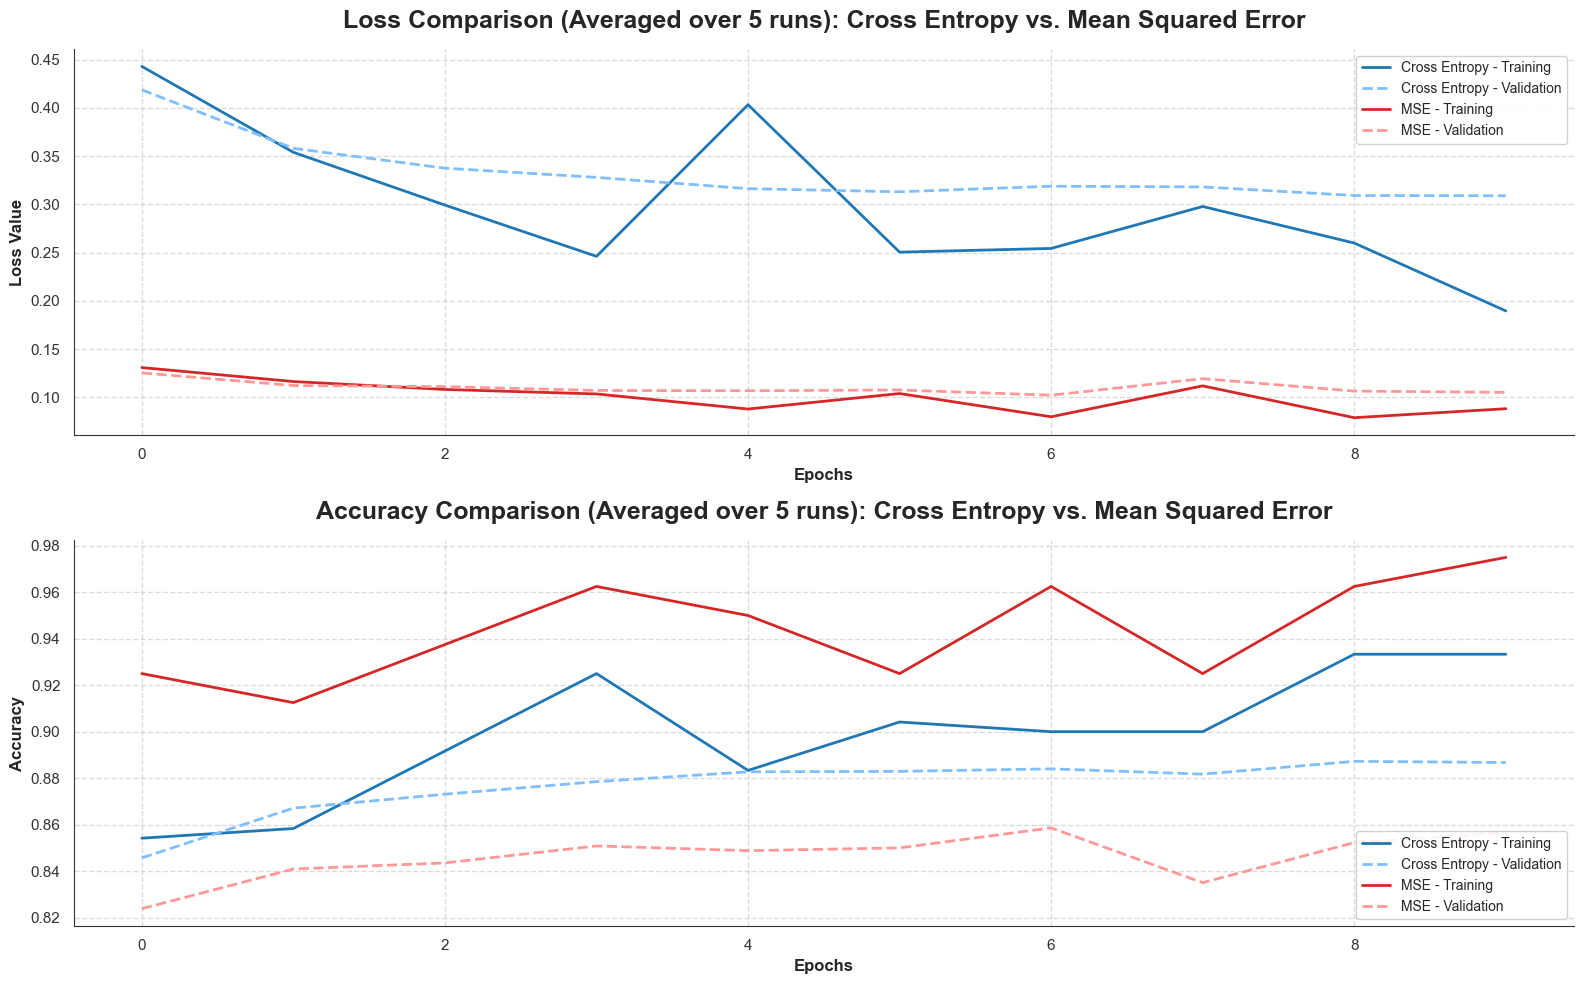

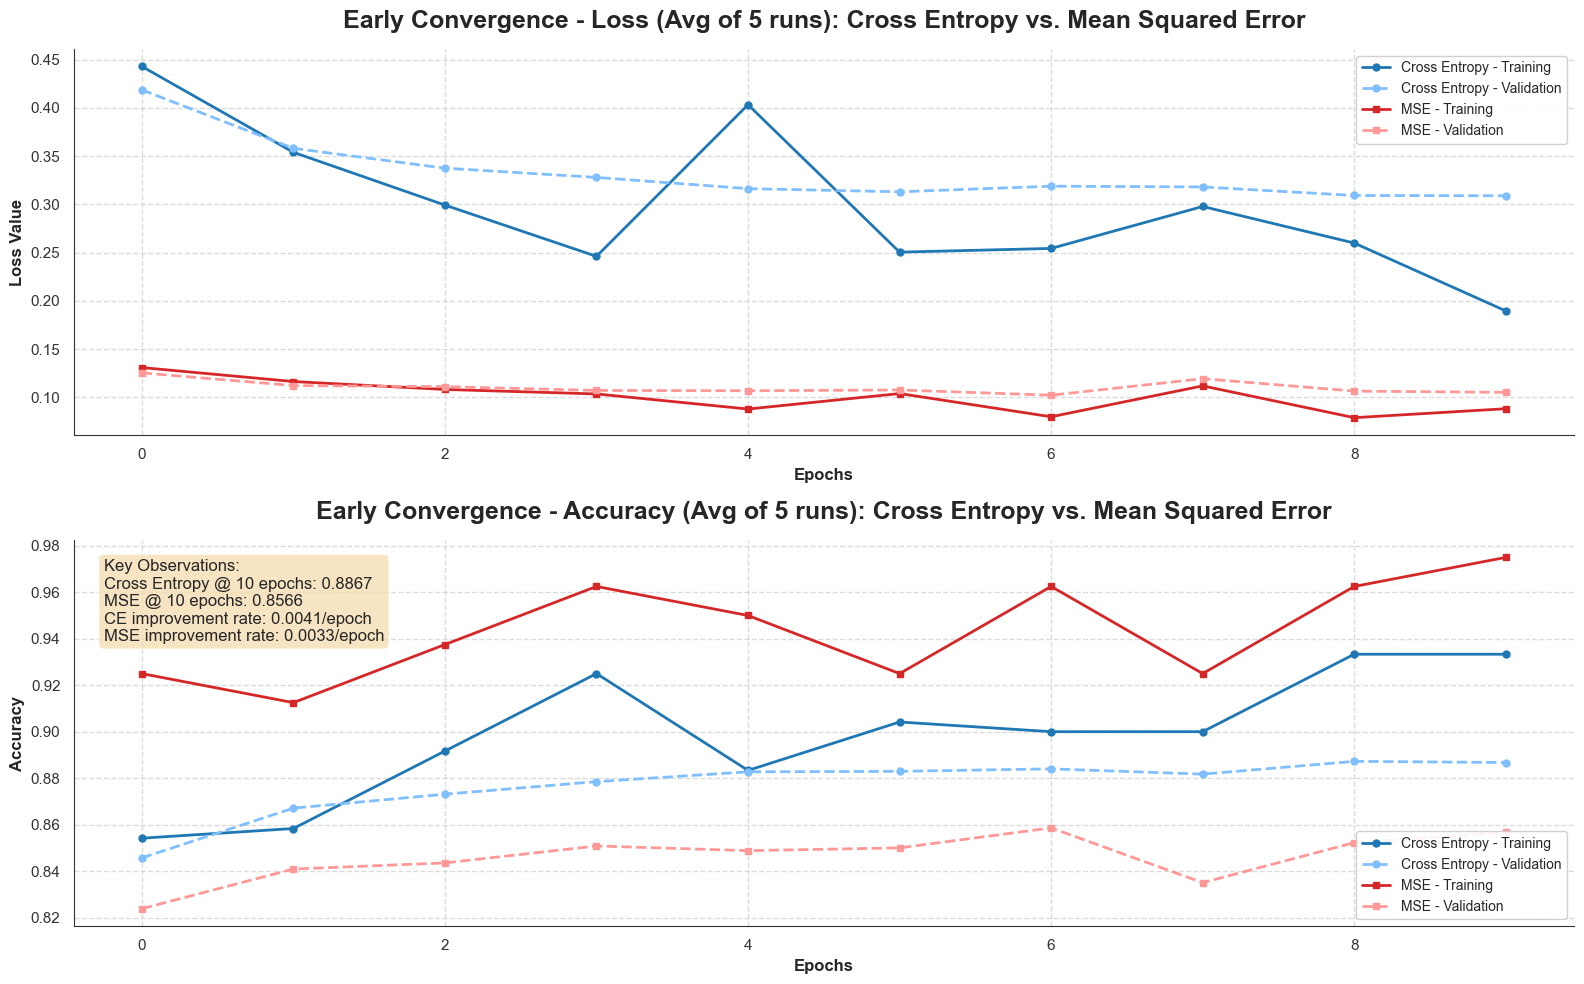

In [16]:
results = plot_loss_comparison(
    ce_histories=ce_histories,
    ce_models=ce_models,
    mse_histories=mse_histories,
    mse_models=mse_models,
    epochs=config_1.epochs
)

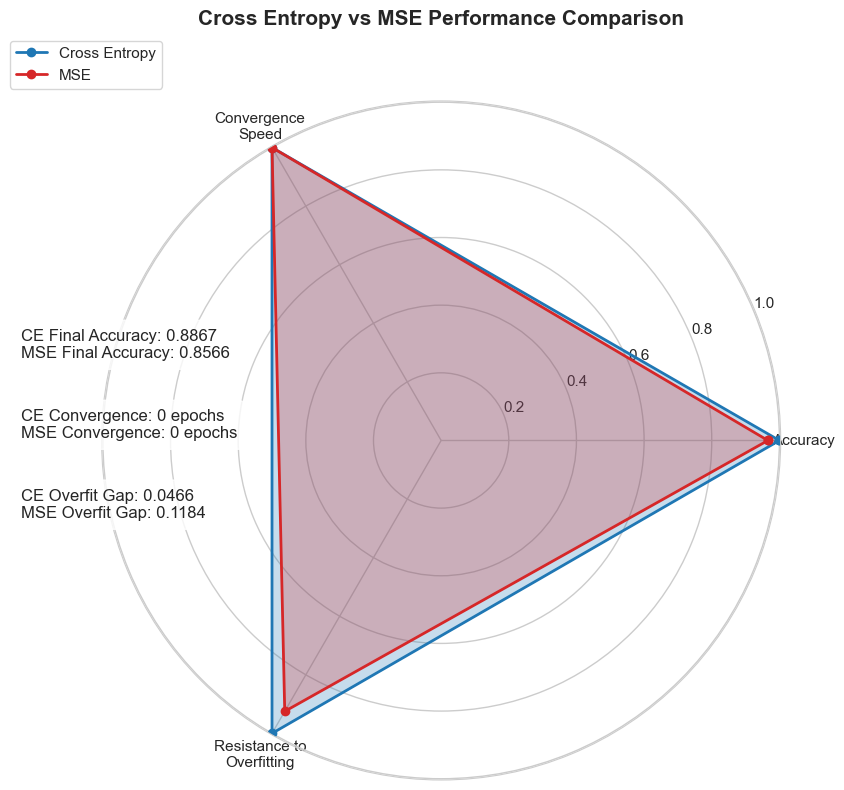

=== CROSS ENTROPY VS MSE COMPARISON ===
Final Cross Entropy Validation Accuracy: 0.8867
Final MSE Validation Accuracy: 0.8566

Convergence Speed (epochs to reach 90% of final accuracy):
Cross Entropy: 0
MSE: 0

Overfitting Assessment (train_acc - val_acc):
Cross Entropy: 0.0466
MSE: 0.1184

=== CONCLUSION ===
Best for Accuracy: Cross Entropy
Best for Convergence Speed: MSE
Best for Avoiding Overfitting: Cross Entropy


{'ce_convergence': 0,
 'mse_convergence': 0,
 'ce_overfit': np.float64(0.04659999999999975),
 'mse_overfit': np.float64(0.11836666666666673),
 'ce_final_acc': np.float64(0.8867333333333335),
 'mse_final_acc': np.float64(0.8566333333333332)}

In [24]:
analyze_results(results)